In [2]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import math
import pickle

from numpy.random import seed
from tensorflow import random

In [3]:
DATA_DIR2 = './data8/'
ids = os.listdir(DATA_DIR2)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR2, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                path = os.path.join(DATA_DIR2, 'images', imgFile)
                throttle = jsonObj['user/throttle']
                if throttle != 0.0 and os.path.exists(path) :
                    image = cv2.imread(path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                    #image = image[65:200, :]
                    #image = cv2.resize(image, (60,35))
                    image = cv2.resize(image, None, fx=0.50, fy= 0.50)
                    #image = cv2.resize(image, (60,60))
                    jsonObj['image'] = image
                    pvm_angels.append(jsonObj)


In [4]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
     A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),
])

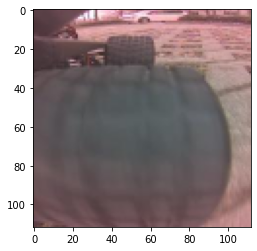

(112, 112, 3)

In [5]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

In [6]:
#prepare and split data



df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])

images = images[4:] 
pwms = pwms[:-4]

angs = list(zip(images, pwms))
rnd.shuffle(angs)
images, pwms = zip(*angs)
images = np.array(images) 
pwms = np.array(pwms)

trainImagesX, testImagesX, trainPwmsX, testPwmsX = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImagesX, valImagesX, trainPwmsX, valPwmsX = train_test_split(trainImagesX, trainPwmsX, test_size=0.135, random_state=42)


In [7]:
#implment augmentation 
augmentedTrainImages = []
for i in range(len(trainImagesX)):
    orig_image = trainImagesX[i]
    augmentedTrainImages.append(orig_image)
    for j in range(9):
        augmentedTrainImages.append(transform(image=orig_image)['image'])

augmentedTrainImages = np.array(augmentedTrainImages)        
augmentedPwms = np.array(trainPwmsX).repeat(10)

augmentedTrainImages.shape, augmentedPwms.shape

((63790, 112, 112, 3), (63790,))

#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_d8_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

# Usage

In [8]:
def calc_ackerman(pwms):
    L = 178 #wheelbase
    b = 165 #

    theta = pwms
    R = L/(np.tan(np.radians(theta))+0.0000001)
    tg_alpha = L/(R+np.sign(theta)*b*25)
    alpha = np.degrees(np.arctan(tg_alpha))

    return alpha

def conv_sigmoid(pwms):
    return (pwms+1)/2.0

#LOAD DATA
with open('car_aug_data_25_vgg.pickle', 'rb') as f:
    data = pickle.load(f)
(augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX) = data


augmentedPwms = calc_ackerman(augmentedPwms)
valPwmsX = calc_ackerman(valPwmsX)
testPwmsX = calc_ackerman(testPwmsX)




In [9]:
augmentedPwms = conv_sigmoid(augmentedPwms)
valPwmsX = conv_sigmoid(valPwmsX)
testPwmsX = conv_sigmoid(testPwmsX)

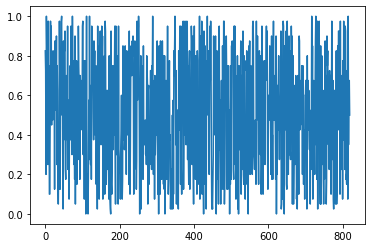

In [10]:
plt.plot(testPwmsX)

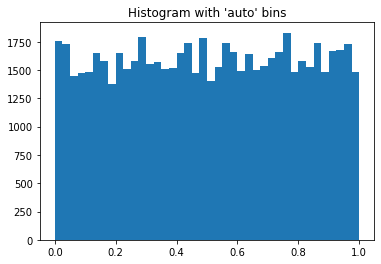

In [11]:
_ = plt.hist(augmentedPwms, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [12]:
seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

input_shape = augmentedTrainImages[0].shape

model = tf.keras.applications.VGG16(
weights='imagenet',
input_shape=input_shape,
include_top=False
)

for layer in model.layers:
      layer.trainable = False
        
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model.input, outputs=x)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImagesX, valPwmsX), epochs=50)

2022-12-15 15:12:59.670330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Epoch 1/50
1994/1994 [==============================] - 27s 12ms/step - loss: 0.0120 - val_loss: 0.0077
Epoch 2/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 3/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 4/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 5/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 6/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 7/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 8/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 9/50
1994/1994 [==============================] - 25s 12ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 10/50
1994/1994 [==============================] - 25s 12m

In [13]:
model.save('50_vgg_d8_move.model')

INFO:tensorflow:Assets written to: 50_vgg_d8_move.model/assets


INFO:tensorflow:Assets written to: 50_vgg_d8_move.model/assets


In [14]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_50_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

import  tensorflow.keras.models
model = tensorflow.keras.models.load_model('25_vgg_d8_move.model')

In [15]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score)


Test loss: 0.003522229380905628


In [16]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 12, 15, 15, 36, 5, 397043)

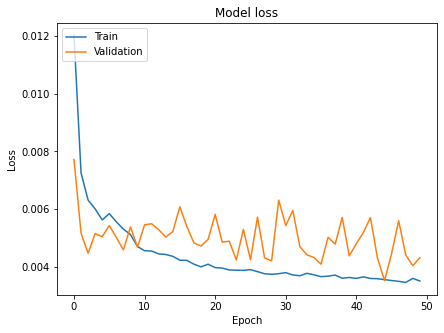

In [17]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [18]:
def show_pwm_prediction3(pwms, preditions, text, start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))    
    
    angs = list(zip(pwms.copy(), preditions))
    res = sorted(angs, key = lambda x: x[0])
    pwms, preditions  = zip(*res)
    
    data = zip()
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

          
    ax.plot(idxs, preditions, 'o', color="blue")
    ax.plot(idxs, pwms, 'o', color="green")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
    #print(pwms[5000], pwms[10000], pwms[15000],pwms[20000], pwms[25000], pwms[30000])
    #print(preditions[5000], preditions[10000], preditions[15000],preditions[20000], preditions[25000], preditions[30000])
    
    

26/26 [==============================] - 0s 11ms/step


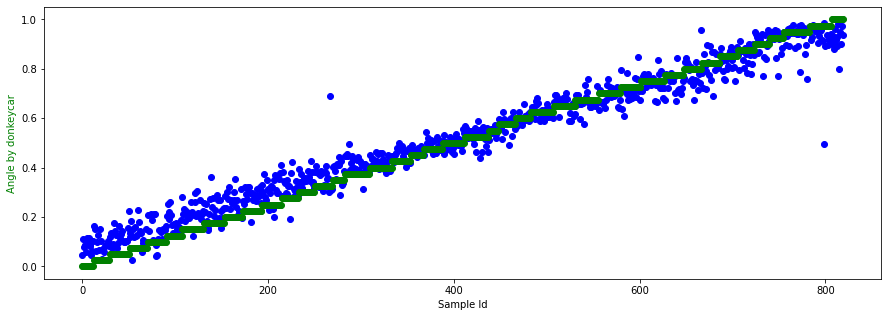

NameError: name 'show_statistics' is not defined

In [19]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX)
predictions2 = np.array(predictions)
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [20]:
residuals = abs(predictions.flatten() - testPwmsX)

In [21]:
residuals.min(),residuals.max(),residuals.mean(), np.median(residuals), np.std(residuals)


(1.968145370501162e-05,
 0.47795692682266266,
 0.044640352638302086,
 0.03664037585258473,
 0.03910841664000544)

In [22]:
a = list(zip(testPwmsX, predictions, residuals))


(array([139., 151., 114., 103.,  94.,  73.,  43.,  26.,  28.,  18.,  12.,
          4.,   6.,   3.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.96814537e-05, 1.19681126e-02, 2.39165437e-02, 3.58649749e-02,
        4.78134060e-02, 5.97618371e-02, 7.17102683e-02, 8.36586994e-02,
        9.56071305e-02, 1.07555562e-01, 1.19503993e-01, 1.31452424e-01,
        1.43400855e-01, 1.55349286e-01, 1.67297717e-01, 1.79246148e-01,
        1.91194580e-01, 2.03143011e-01, 2.15091442e-01, 2.27039873e-01,
        2.38988304e-01, 2.50936735e-01, 2.62885166e-01, 2.74833598e-01,
        2.86782029e-01, 2.98730460e-01, 3.10678891e-01, 3.22627322e-01,
        3.34575753e-01, 3.46524184e-01, 3.58472615e-01, 3.70421047e-01,
        3.82369478e-01, 3.94317909e-01, 4.06266340e-01, 4.18214771e-01,
        4.30163202e-01, 4.42111633e-01, 4.54060065e-01, 4.66008496e-01,
      

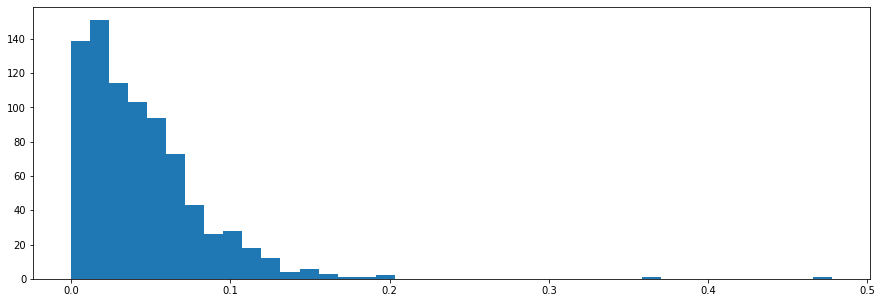

In [23]:
plt.hist(residuals, bins=40)

In [24]:
predictions=model.predict(augmentedTrainImages)

1994/1994 [==============================] - 21s 11ms/step


In [30]:
len(augmentedTrainImages)

63790

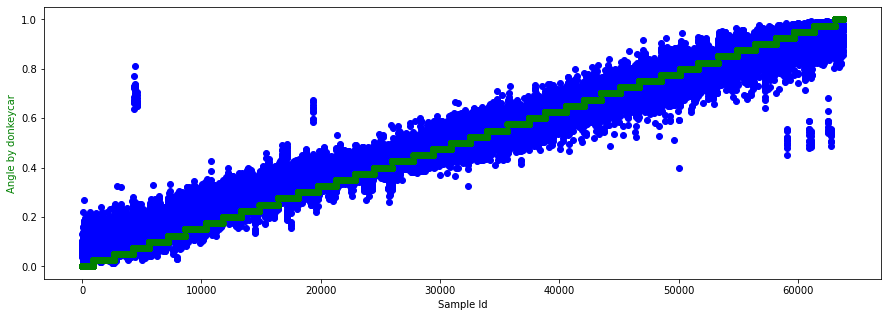

NameError: name 'show_statistics' is not defined

In [28]:


pwms2 = np.array(augmentedPwms[0:])
predictions2 = np.array(predictions[0:])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)


-1 delta:  0.7374855160713198 orig aug:  0.07499999999999968 pred:  0.8124855


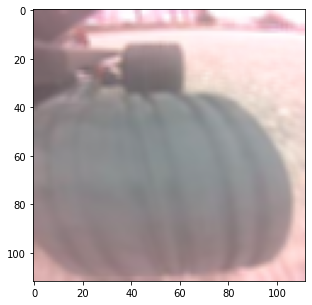

-2 delta:  0.6967304229736331 orig aug:  0.07499999999999968 pred:  0.7717304


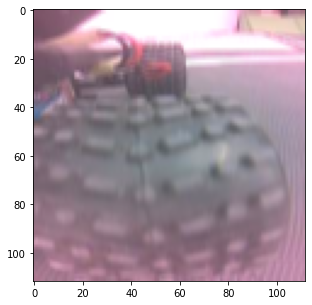

-3 delta:  0.664018261432648 orig aug:  0.07499999999999968 pred:  0.73901826


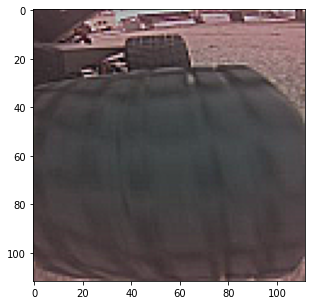

-4 delta:  0.6574965596199038 orig aug:  0.07499999999999968 pred:  0.73249656


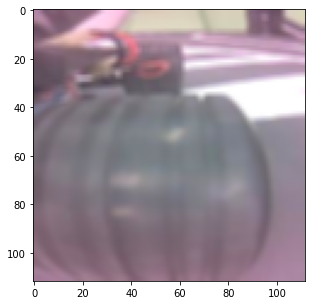

-5 delta:  0.6564926981925967 orig aug:  0.07499999999999968 pred:  0.7314927


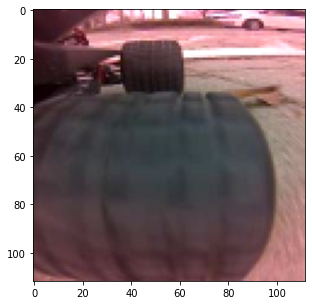

-6 delta:  0.6512704372406009 orig aug:  0.07499999999999968 pred:  0.72627044


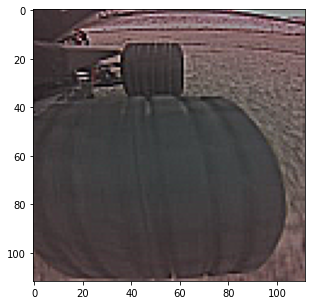

-7 delta:  0.6502677679061892 orig aug:  0.07499999999999968 pred:  0.72526777


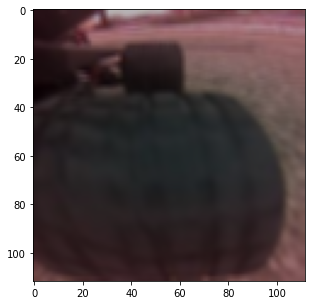

-8 delta:  0.6485604524612429 orig aug:  0.07499999999999968 pred:  0.72356045


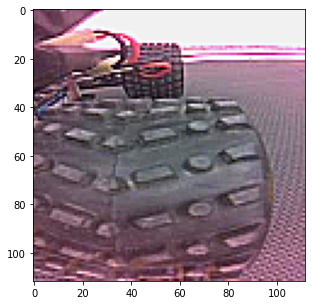

-9 delta:  0.646059322357178 orig aug:  0.07499999999999968 pred:  0.7210593


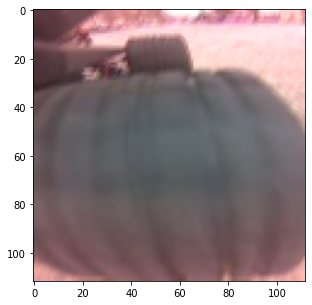

In [45]:
residuals2 = abs(predictions2.flatten() - augmentedPwms)

b = list(zip(residuals2, augmentedPwms, augmentedTrainImages, predictions2.flatten()))
res = sorted(b, key = lambda x: x[0])
residuals3, augmentedPwms3, augmentedTrainImages3, predictions3  = zip(*res)

for idx in range(1,10):

    print(-idx, 'delta: ',residuals3[-idx],'orig aug: ', augmentedPwms3[-idx], 'pred: ',predictions3[-idx])
    plt.imshow(augmentedTrainImages3[idx])
    plt.show()
    
    

In [41]:

residuals3[-1]

0.7374855160713198

In [21]:
def show_pwm_prediction(pwms, preditions, throttle, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, throttle, color="red")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle and Throttle by donkeycar', color="green")
    
    ax2 = ax.twinx()
    ax2.plot(idxs, preditions)
    ax2.set_ylabel('Angle by camera', color="blue")
    
    fig.set_figwidth(15)
    plt.show()

def show_pwm_prediction2(pwms, preditions, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, preditions, color="blue")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
def show_statistics(pwms, predictions, frames=None):

    #print('Sample count: ', len(predictions))
    #print('Cov', np.corrcoef([pwms,predictions]))    

    if frames == None:
        frames = len(predictions)
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    #sse = np.sum(((predictions3 - pwms)**2))
    sse = np.sum(((predictions - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

In [8]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-11-23 17:54:22.818577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
